In [7]:
using JuMP, Gurobi

I ended up using node numbering that is slightly different from what we have in the package, so that N stages means N decision stages plus the initial health state.

![Limited memory influence diagram of the pig farm problem](pigfarm_limid.png)

Using Algorithm 1 from Parmentier et al. (2020), we get an RJT:

![Rooted Junction Tree of the pig farm problem](pigfarm_rjt.png)

In [9]:
function solve_pigfarm(n_stages; verbose=false)
    model = Model()
    if !verbose
        set_silent(model)
    end
    optimizer = optimizer_with_attributes(
        () -> Gurobi.Optimizer(Gurobi.Env()),
        "IntFeasTol"      => 1e-9,
        "TimeLimit"       => 3600,
        # "DualReductions"  => 0,
    )
    set_optimizer(model, optimizer)

    # Index sets
    N = 1:n_stages
    H = 1:2 # Ill/healthy
    T = 1:2 # +/-
    D = 1:2 # Treat/pass
    # The reason we introduce states for value nodes is that they could be stochastic
    U_treat = 1:2 # Treat/pass 
    U_sell = 1:2 # Ill/healthy

    # Treatment costs 
    cost_treat = zeros(length(D),length(U_treat))
    cost_treat[1,1] = -100

    # Profit from selling the pig in the end
    profit_sell = zeros(length(H),length(U_sell))
    profit_sell[1,1] = 300
    profit_sell[2,2] = 1000

    # Initial probability of pig being ill/healthy
    p_init = [0.1 0.9]

    # Transition probabilities of the health states
    p_trans = zeros(length(H),length(D),length(H))
    p_trans[1,1,:] = [0.5 0.5] # Ill, treated
    p_trans[1,2,:] = [0.9 0.1] # Ill, not treated
    p_trans[2,1,:] = [0.1 0.9] # Healthy, treated
    p_trans[2,2,:] = [0.2 0.8] # Healthy, not treated

    # Probabilities of getting positive/negative result from the test
    p_res = zeros(length(H),length(T))
    p_res[1,:] = [0.8 0.2] # Ill
    p_res[2,:] = [0.1 0.9] # Healthy

    # Variables corresponding to the nodes in the RJT
    @variable(model, μ_h0[H] >= 0)
    @variable(model, μ_ht[N,H,T] >= 0)
    @variable(model, μ_htd[N,H,T,D] >= 0)
    @variable(model, μ_hdh[N,H,D,H] >= 0)
    @variable(model, μ_du[N,D,U_treat] >= 0)
    @variable(model, μ_hu[H,U_sell] >= 0)
    # Decision strategy variable
    @variable(model, δ[N,T,D], Bin)

    # Objective function
    @objective(model, Max, sum(μ_du[n,d,u]*cost_treat[d,u] for n in N, d in D, u in U_treat) + sum(μ_hu[h,u]*profit_sell[h,u] for h in H, u in U_sell))

    # Probability distributions μ sum to 1
    @constraint(model, sum(μ_h0) == 1)
    @constraint(model, [n in N], sum(μ_ht[n,h,t] for h in H, t in T) == 1)
    @constraint(model, [n in N], sum(μ_htd[n,h,t,d] for h in H, t in T, d in D) == 1)
    @constraint(model, [n in N], sum(μ_hdh[n,h,d,hh] for h in H, d in D, hh in H) == 1)
    @constraint(model, [n in N], sum(μ_du[n,d,u] for d in D, u in U_treat) == 1)
    @constraint(model, sum(μ_hu[h,u] for h in H, u in U_sell) == 1)

    # Local consistency constraints
    @constraint(model, [h in H], μ_h0[h] == sum(μ_ht[1,h,t] for t in T))
    @constraint(model, [n in setdiff(N,1), h in H], sum(μ_hdh[n-1,hh,d,h] for hh in H, d in D) == sum(μ_ht[n,h,t] for t in T))
    @constraint(model, [n in N, h in H, t in T], μ_ht[n,h,t] == sum(μ_htd[n,h,t,d] for d in D))
    @constraint(model, [n in N, h in H, d in D], sum(μ_htd[n,h,t,d] for t in T) == sum(μ_hdh[n,h,d,hh] for hh in H))
    @constraint(model, [n in N, d in D], sum(μ_htd[n,h,t,d] for h in H, t in T) == sum(μ_du[n,d,u] for u in U_treat))
    @constraint(model, [hh in H], sum(μ_hdh[length(N),h,d,hh] for h in H, d in D) == sum(μ_hu[hh,u] for u in U_sell))

    # Moments μ_{\breve{C}_v} (the moments from above, but with the last variable dropped out)
    # Some such moments were already created, for example μ_htd becomes μ_ht
    @variable(model, μ_d[N,D] >= 0)
    @variable(model, μ_hd[N,H,D] >= 0)
    @variable(model, μ_h[N,H] >= 0)

    # μ_{\breve{C}_v} = ∑_{x_v} μ_{C_v}
    @constraint(model, [n in setdiff(N,1), h in H], sum(μ_ht[n,h,t] for t in T) == μ_h[n-1,h])
    # @constraint(model, [n in N, h in H, t in T], sum(μ_htd[n,h,t,d] for d in D) == μ_ht[n,h,t]) # This was already introduced above in the local consistency
    @constraint(model, [n in N, h in H, d in D], sum(μ_hdh[n,h,d,hh] for hh in H) == μ_hd[n,h,d])
    @constraint(model, [n in N, d in D], sum(μ_du[n,d,u] for u in U_treat) == μ_d[n,d])
    @constraint(model, [h in H], sum(μ_hu[h,u] for u in U_sell) == μ_h[length(N),h])

    # Factorization constraints (Corollary 3 in Parmentier et al.)
    @constraint(model, [h in H], μ_h0[h] == p_init[h])
    @constraint(model, [n in setdiff(N,1), h in H, t in T], μ_ht[n,h,t] == μ_h[n-1,h]*p_res[h,t])
    # @constraint(model, [n in N, h in H, t in T, d in D], μ_htd[n,h,t,d] == μ_ht[n,h,t]*δ[n,t,d])             # NONLINEAR, does not seem to be a problem for Gurobi
    @constraint(model, [n in N, h in H, t in T, d in D], δ[n,t,d] => {μ_htd[n,h,t,d] == μ_ht[n,h,t]})
    @constraint(model, [n in N, h in H, t in T, d in D], !δ[n,t,d] => {μ_htd[n,h,t,d] == 0})
    @constraint(model, [n in N, h in H, d in D, hh in H], μ_hdh[n,h,d,hh] == μ_hd[n,h,d]*p_trans[h,d,hh])
    @constraint(model, [n in N, d in D, u in U_treat], μ_du[n,d,u] == μ_d[n,d]*((d==u) ? 1 : 0))
    @constraint(model, [h in H, u in U_sell], μ_hu[h,u] == μ_h[length(N),h]*((h==u) ? 1 : 0))

    optimize!(model)

    # solution_summary(model)
    
    
    return objective_value(model), value.(δ), solve_time(model)
end

solve_pigfarm (generic function with 1 method)

In [10]:
N_arr = [1; 2; 3; 4; 5; 10; 25; 50; 100; 200; 400; 800; 1600]
N_arr = [1; 2; 3; 4; 5; 6; 7; 8]
sol_times = []
n_sample = 10
for n_stages in N_arr
    total_time = 0
    for i in 1:n_sample
        _, _, t = solve_pigfarm(n_stages)
        total_time+=t
    end
    push!(sol_times, total_time/n_sample)
end
        

Set parameter TokenServer to value "Lic-gurobi.aalto.fi"
Set parameter IntFeasTol to value 1e-09
Set parameter TimeLimit to value 3600
Set parameter TokenServer to value "Lic-gurobi.aalto.fi"
Set parameter IntFeasTol to value 1e-09
Set parameter TimeLimit to value 3600
Set parameter TokenServer to value "Lic-gurobi.aalto.fi"
Set parameter IntFeasTol to value 1e-09
Set parameter TimeLimit to value 3600
Set parameter TokenServer to value "Lic-gurobi.aalto.fi"
Set parameter IntFeasTol to value 1e-09
Set parameter TimeLimit to value 3600
Set parameter TokenServer to value "Lic-gurobi.aalto.fi"
Set parameter IntFeasTol to value 1e-09
Set parameter TimeLimit to value 3600
Set parameter TokenServer to value "Lic-gurobi.aalto.fi"
Set parameter IntFeasTol to value 1e-09
Set parameter TimeLimit to value 3600
Set parameter TokenServer to value "Lic-gurobi.aalto.fi"
Set parameter IntFeasTol to value 1e-09
Set parameter TimeLimit to value 3600
Set parameter TokenServer to value "Lic-gurobi.aalto.fi

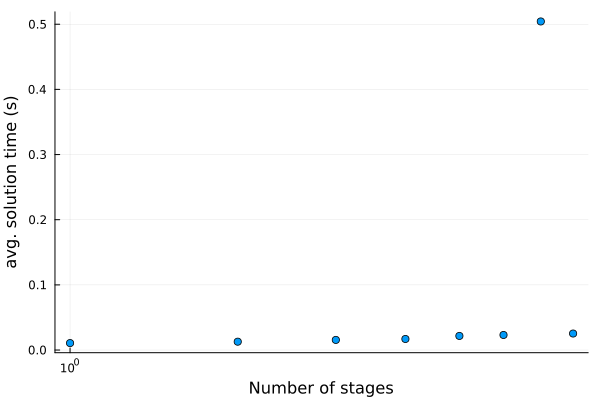

In [11]:
using Plots
scatter(N_arr, sol_times, xaxis=:log, xticks=[1, 10, 100, 1000, 10000], xlabel="Number of stages", ylabel="avg. solution time (s)", label=false)

In [6]:
sol_times[2:end]

7-element Vector{Any}:
 0.4498893737792969
 0.49461495876312256
 0.5159060001373291
 0.5783533811569214
 0.5958436727523804
 0.5831738948822022
 0.5279922962188721